# Visualización de grafos TTDP
Este cuaderno carga archivos GraphML generados en `experiments/graphs/` y los visualiza con NetworkX + Matplotlib.

In [7]:
from pathlib import Path
import math
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Resolver ruta a experiments/graphs relativo al cwd del notebook
repo_root = Path.cwd()
candidates = [repo_root, repo_root.parent, repo_root.parent.parent, repo_root.parent.parent.parent]
graphs_dir = None
for base in candidates:
    cand = base / 'experiments' / 'graphs'
    if cand.exists():
        graphs_dir = cand
        break
# Fallback: usar cwd/experiments/graphs aunque no exista aún
if graphs_dir is None:
    graphs_dir = repo_root / 'experiments' / 'graphs'

graphml_files = sorted(graphs_dir.glob('*.graphml'))
graphs_dir, graphml_files[:5]

(WindowsPath('c:/Users/juann/OneDrive - Pontificia Universidad Javeriana/Trabajo de Grado/ttdp-trabajo-grado/experiments/graphs'),
 [WindowsPath('c:/Users/juann/OneDrive - Pontificia Universidad Javeriana/Trabajo de Grado/ttdp-trabajo-grado/experiments/graphs/hptoptw-j11a_knnall_alpha0.1_tw1_undir.graphml')])

## Selección de archivo
Ajusta `graph_path` para visualizar un archivo específico.

In [8]:
# Selecciona el primer archivo por defecto si existe
graph_path = graphml_files[0] if graphml_files else None
if graph_path is None:
    print('No se encontraron archivos .graphml en', graphs_dir.as_posix())
graph_path

WindowsPath('c:/Users/juann/OneDrive - Pontificia Universidad Javeriana/Trabajo de Grado/ttdp-trabajo-grado/experiments/graphs/hptoptw-j11a_knnall_alpha0.1_tw1_undir.graphml')

## Carga y utilidades de visualización

In [9]:
def load_graph(graphml_path):
    G = nx.read_graphml(graphml_path)
    # Convertir atributos numéricos a float/int si vienen como strings
    for n, d in G.nodes(data=True):
        for k in ['x','y','open','close','service','profit','is_depot']:
            if k in d:
                try:
                    if k == 'is_depot':
                        d[k] = int(d[k])
                    else:
                        d[k] = float(d[k])
                except Exception:
                    pass
    for u, v, d in G.edges(data=True):
        for k in ['dist','weight','tw_slack']:
            if k in d:
                try:
                    d[k] = float(d[k])
                except Exception:
                    pass
        if 'tw_feasible' in d:
            if isinstance(d['tw_feasible'], str):
                d['tw_feasible'] = d['tw_feasible'].lower() in ('1','true','yes')
            else:
                d['tw_feasible'] = bool(d['tw_feasible'])
    return G

def compute_layout(G, prefer_xy=True, seed=42):
    if prefer_xy and 'x' in next(iter(G.nodes(data=True)))[1] and 'y' in next(iter(G.nodes(data=True)))[1]:
        pos = {n: (float(d['x']), float(d['y'])) for n, d in G.nodes(data=True)}
    else:
        pos = nx.spring_layout(G, seed=seed)
    return pos

def plot_graph(G, pos=None, with_labels=True, save_path=None):
    if pos is None:
        pos = compute_layout(G)
    depot_nodes = [n for n, d in G.nodes(data=True) if int(d.get('is_depot', 0)) == 1]
    depot = depot_nodes[0] if depot_nodes else None
    node_colors = ['red' if n == depot else 'steelblue' for n in G.nodes()]
    node_sizes = [80 + 3 * float(G.nodes[n].get('profit', 0)) for n in G.nodes()]
    edge_colors = ['tab:green' if bool(d.get('tw_feasible', True)) else 'tab:red' for _, _, d in G.edges(data=True)]
    edge_widths = [1 + 3 * float(d.get('weight', 1.0)) for _, _, d in G.edges(data=True)]
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, edge_color=edge_colors, width=edge_widths, with_labels=with_labels, font_size=8)
    plt.axis('off')
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()

def summary(G):
    import numpy as np
    n, m = G.number_of_nodes(), G.number_of_edges()
    deg = np.mean([d for _, d in G.degree()]) if n else 0
    print(f'nodes={n} edges={m} avg_degree={deg:.2f}')
    if m:
        dists = [float(d.get('dist', 0)) for _, _, d in G.edges(data=True)]
        weights = [float(d.get('weight', 1)) for _, _, d in G.edges(data=True)]
        import numpy as np
        corr = np.corrcoef(np.array(dists), -np.array(weights))[0, 1]
        print('corr(dist, -weight)=', round(float(corr), 3))
    return n, m


## Visualización

nodes=11 edges=49 avg_degree=8.91
corr(dist, -weight)= 0.91


C:\Users\juann\AppData\Local\Temp\ipykernel_24280\1006698853.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


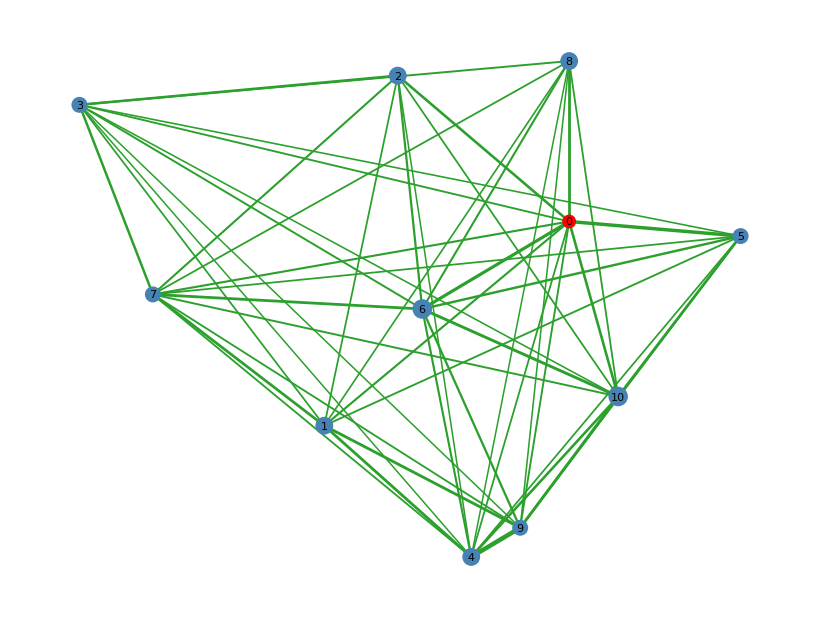

In [10]:
if graph_path is None:
    print('No se encontraron archivos GraphML en', graphs_dir.as_posix())
else:
    G = load_graph(graph_path)
    summary(G)
    pos = compute_layout(G, prefer_xy=True, seed=42)
    out_png = graph_path.with_suffix('').as_posix() + '_preview.png'
    plot_graph(G, pos=pos, with_labels=True, save_path=out_png)
    out_png

## Generación de grafos para múltiples instancias
Esta celda construye grafos para varias instancias sintéticas (con distinto número de POIs) usando el builder `src/graph/graph_builder.py`.

In [11]:
import subprocess, sys
from pathlib import Path

# Resolver rutas relativas al repo a partir de graphs_dir detectado arriba
repo_root = graphs_dir.parent.parent
builder = repo_root / 'src' / 'graph' / 'graph_builder.py'
data_syn = repo_root / 'data' / 'synthetic'
graphs_out = graphs_dir

instances = [
    'hptoptw-j11b.csv',
    'hptoptw-j16a.csv',
    'hptoptw-j16b.csv',
    'hptoptw-j21a.csv',
]

print('Usando builder:', builder.as_posix())
print('Guardando en   :', graphs_out.as_posix())

for fname in instances:
    csv_path = data_syn / fname
    if not csv_path.exists():
        print('[WARN] No existe', csv_path.as_posix());
        continue
    cmd = [sys.executable, str(builder), '--file', str(csv_path), '--knn', '10', '--alpha', '0.05']
    print('>>', ' '.join(cmd))
    res = subprocess.run(cmd, capture_output=True, text=True)
    if res.returncode != 0:
        print('[ERROR]', res.stderr)
    else:
        print(res.stdout.strip())

# Actualizar listado de archivos generados
graphml_files = sorted(graphs_out.glob('*.graphml'))
len(graphml_files), [p.name for p in graphml_files][-6:]


Usando builder: c:/Users/juann/OneDrive - Pontificia Universidad Javeriana/Trabajo de Grado/ttdp-trabajo-grado/src/graph/graph_builder.py
Guardando en   : c:/Users/juann/OneDrive - Pontificia Universidad Javeriana/Trabajo de Grado/ttdp-trabajo-grado/experiments/graphs
>> c:\Users\juann\anaconda3\python.exe c:\Users\juann\OneDrive - Pontificia Universidad Javeriana\Trabajo de Grado\ttdp-trabajo-grado\src\graph\graph_builder.py --file c:\Users\juann\OneDrive - Pontificia Universidad Javeriana\Trabajo de Grado\ttdp-trabajo-grado\data\synthetic\hptoptw-j11b.csv --knn 10 --alpha 0.05
Saved GraphML -> experiments\graphs\hptoptw-j11b_knn10_alpha0.05_tw1_undir.graphml
Saved edgelist -> experiments\graphs\hptoptw-j11b_knn10_alpha0.05_tw1_undir_edgelist.csv
>> c:\Users\juann\anaconda3\python.exe c:\Users\juann\OneDrive - Pontificia Universidad Javeriana\Trabajo de Grado\ttdp-trabajo-grado\src\graph\graph_builder.py --file c:\Users\juann\OneDrive - Pontificia Universidad Javeriana\Trabajo de Grad

(1, ['hptoptw-j11a_knnall_alpha0.1_tw1_undir.graphml'])

## Visualización de todos los grafos generados
Dibuja una vista previa para cada GraphML recientemente generado.

Plot -> hptoptw-j11a_knnall_alpha0.1_tw1_undir.graphml
nodes=11 edges=49 avg_degree=8.91
corr(dist, -weight)= 0.91


C:\Users\juann\AppData\Local\Temp\ipykernel_24280\1006698853.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


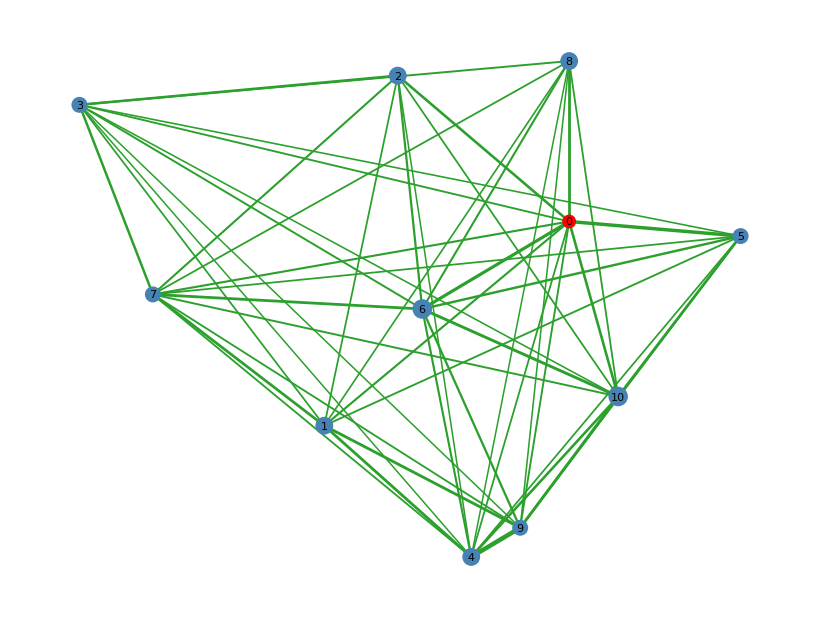

Previews guardados junto a los .graphml


In [13]:
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt

if not graphml_files:
    print('No hay archivos GraphML para visualizar en', graphs_dir.as_posix())
else:
    for gpath in graphml_files:
        print('Plot ->', gpath.name)
        G = load_graph(gpath)
        summary(G)
        pos = compute_layout(G, prefer_xy=True, seed=42)
        out_png = Path(str(gpath).rsplit('.',1)[0] + '_preview.png')
        plot_graph(G, pos=pos, with_labels=True, save_path=out_png)
    print('Previews guardados junto a los .graphml')


## ¿Cómo funciona el generador de grafos?
- Entrada: CSV sintético con columnas `id,x,y,a,b,s,p` (+ `is_depot` opcional) y metadatos globales (`k,i,u,l`).
- Nodos: uno por POI, con atributos (`x,y,open,close,service,profit,is_depot`).
- Aristas: calculadas entre pares (o top-`k` vecinos) con:
  - `dist`: distancia euclídea.
  - `weight = exp(-alpha * dist)`: peso usado por los random walks.
  - `tw_feasible`, `tw_slack`: compatibilidad y holgura temporal local i→j.
- Filtro TW: si está activo, se descartan aristas no factibles (en al menos una dirección si es no dirigido).
- Salida: `GraphML` y `edgelist.csv` en `experiments/graphs/`, con metadatos del grafo en `G.graph[...]`.
- Uso CLI: `python src/graph/graph_builder.py --file data/synthetic/hptoptw-j11a.csv --knn 10 --alpha 0.05`.